# Constituency combine notebook

This notebook takes the four different boundaries, combines into a single format, and uses 3 letter codes from https://automaticknowledge.org/wpc-hex/ as unique identifiers.

Where avaliable, gss codes are added.

In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


# top_level is where pyproject.toml is
top_level = Path.cwd().parent
while (top_level / "pyproject.toml").is_file() == False:
    top_level = top_level.parent

geo_dir = top_level / "data" / "raw" / "geo"
assert geo_dir.is_dir()
nations = ["e", "s", "w", "n"]

In [2]:
english_package = (
    geo_dir / "cons" / "en" / "2023_06_27_Final_recommendations_England.gpkg"
)
english_package_parquet = top_level / "data" / "interim" / "eng_cons.parquet"

# quickly cache this as geoparquet because it's too big to store
if english_package.exists():
    english_gdf = gpd.read_file(english_package).to_crs("EPSG:4326")
    english_gdf.to_parquet(english_package_parquet)
else:
    english_gdf = gpd.read_parquet(english_package_parquet)

english_gdf = english_gdf.rename(
    columns={
        "Constituen": "name",
        "Area km2": "area",
        "Electorate": "electorate",
        "Designatio": "type",
        "Region": "region",
        "Sub region": "sub_region",
    }
)

# drop density

english_gdf = english_gdf.drop(columns=["Density"])
english_gdf["nation"] = "England"

# in type column, drop the ' Constituency' and make it lowercase
english_gdf["type"] = english_gdf["type"].str.replace(" Constituency", "").str.lower()

english_gdf.head()

,ID,name,electorate,type,region,area,sub_region,geometry,nation
0,1,Broadland and Fakenham,72907,county,Eastern,720.52,Norfolk and Suffolk,"MULTIPOLYGON Z (((1.67679 52.61431 0.00000, 1....",England
1,2,Great Yarmouth,70077,county,Eastern,182.43,Norfolk and Suffolk,"MULTIPOLYGON Z (((1.74002 52.53334 0.00000, 1....",England
2,3,North Norfolk,70719,county,Eastern,792.48,Norfolk and Suffolk,"MULTIPOLYGON Z (((1.57352 52.70262 0.00000, 1....",England
3,4,Mid Norfolk,71060,county,Eastern,838.86,Norfolk and Suffolk,"MULTIPOLYGON Z (((1.07903 52.50686 0.00000, 1....",England
4,5,South West Norfolk,72496,county,Eastern,1160.93,Norfolk and Suffolk,"MULTIPOLYGON Z (((0.74179 52.39268 0.00000, 0....",England


In [3]:
scot_path = (
    geo_dir
    / "cons"
    / "sc"
    / "All_Scotland_Final_Recommended_Constituencies_2023_Review.shp"
)

scot_package_parquet = top_level / "data" / "interim" / "scot_cons.parquet"

# quickly cache this as geoparquet because it's too big to store
if scot_path.exists():
    scot_gdf = gpd.read_file(scot_path).to_crs("EPSG:4326")
    scot_gdf.to_parquet(scot_package_parquet)
else:
    scot_gdf = gpd.read_parquet(scot_package_parquet)


scot_gdf = scot_gdf.rename(
    columns={
        "NAME": "name",
        "AREA": "area",
        "Designatio": "type",
        "Electors": "electorate",
    }
).drop(columns=["Source", "Review", "Submitted", "Area_Type"])

scot_gdf["region"] = "Scotland"
scot_gdf["sub_region"] = ""
scot_gdf["nation"] = "Scotland"

# change 'County' and 'burgh' in type column to 'county' and 'borough'
scot_gdf["type"] = scot_gdf["type"].str.lower()
scot_gdf["type"] = scot_gdf["type"].str.replace("burgh", "borough")

scot_gdf.head()

,name,area,type,electorate,geometry,region,sub_region,nation
0,"Berwickshire, Roxburgh and Selkirk",3841.930,county,74687.0,"POLYGON ((-3.09188 55.72213, -3.09179 55.72263...",Scotland,,Scotland
1,Arbroath and Broughty Ferry,421.698,county,76810.0,"POLYGON ((-2.89108 56.54469, -2.89079 56.54528...",Scotland,,Scotland
2,Dunfermline and Dollar,279.157,county,70725.0,"POLYGON ((-3.41663 56.09272, -3.41666 56.09269...",Scotland,,Scotland
3,Airdrie and Shotts,238.263,county,70420.0,"POLYGON ((-3.89336 55.79471, -3.89342 55.79469...",Scotland,,Scotland
4,East Kilbride and Strathaven,304.595,county,75161.0,"POLYGON ((-4.14769 55.80494, -4.14831 55.80385...",Scotland,,Scotland


In [4]:
wales_path = geo_dir / "cons" / "wa" / "Final Recommendations_region.shp"

wales_package_parquet = top_level / "data" / "interim" / "wales_cons.parquet"

# quickly cache this as geoparquet because it's too big to store
if wales_path.exists():
    wales_gdf = gpd.read_file(wales_path).to_crs(epsg=4326)
    wales_gdf.to_parquet(wales_package_parquet)
else:
    wales_gdf = gpd.read_parquet(wales_package_parquet)

wales_gdf = wales_gdf.rename(
    columns={"Official_N": "name", "Alternativ": "name_cy", "Electors": "electorate"}
)
wales_gdf = wales_gdf.drop(columns=["Constituen"])
wales_gdf["region"] = "Wales"
wales_gdf["sub_region"] = ""
wales_gdf["nation"] = "Wales"

borough_constituencies = [
    "Cardiff East",
    "Cardiff North",
    "Cardiff South and Penarth",
    "Cardiff West",
]

# populate type column with 'borough' for borough constituencies, and 'county' otherwise
wales_gdf.loc[wales_gdf["name"].isin(borough_constituencies), "type"] = "borough"
wales_gdf.loc[~wales_gdf["name"].isin(borough_constituencies), "type"] = "county"

name_corrections = {
    "Montgomeryshire and Glyndwr": "Montgomeryshire and Glyndŵr",
    "Ynys Mon": "Ynys Môn",
}

wales_gdf["name"] = wales_gdf["name"].replace(name_corrections)

wales_gdf.head()

,name,name_cy,electorate,geometry,region,sub_region,nation,type
0,Aberafan Maesteg,NaN,69817,"POLYGON ((-3.56176 51.64742, -3.56195 51.64725...",Wales,,Wales,county
1,Alyn and Deeside,Alun a Glannau Dyfrdwy,75695,"POLYGON ((-2.92033 53.18330, -2.92035 53.18294...",Wales,,Wales,county
2,Bangor Aberconwy,NaN,70468,"POLYGON ((-3.30310 53.09046, -3.30314 53.09026...",Wales,,Wales,county
3,Blaenau Gwent and Rhymney,Blaenau Gwent a Rhymni,71079,"POLYGON ((-3.10611 51.76125, -3.11283 51.75922...",Wales,,Wales,county
4,"Brecon, Radnor and Cwm Tawe","Aberhonddu, Maesyfed a Chwm Tawe",72113,"POLYGON ((-2.94962 52.26951, -2.94963 52.26946...",Wales,,Wales,county


In [5]:
ni_path = geo_dir / "cons" / "ni" / "Final_Recommendations_2023.shp"
ni_package_parquet = top_level / "data" / "interim" / "ni_cons.parquet"

# quickly cache this as geoparquet because it's too big to store
if ni_path.exists():
    ni_gdf = gpd.read_file(ni_path).to_crs(epsg=4326)
    ni_gdf.to_parquet(ni_package_parquet)
else:
    ni_gdf = gpd.read_parquet(ni_package_parquet)

ni_gdf = ni_gdf.rename(columns={"Constituen": "name", "Electorate": "electorate"})
ni_gdf = ni_gdf.drop(columns=["Shape_Leng", "Shape_Area"])
ni_gdf["region"] = "Northern Ireland"
ni_gdf["nation"] = "Northern Ireland"

borough_constituencies = [
    "Belfast East",
    "Belfast North",
    "Belfast South and Mid Down",
    "Belfast West",
]

# populate type column with 'borough' for borough constituencies, and 'county' otherwise
ni_gdf.loc[ni_gdf["name"].isin(borough_constituencies), "type"] = "borough"
ni_gdf.loc[~ni_gdf["name"].isin(borough_constituencies), "type"] = "county"


ni_gdf.head()

,name,electorate,geometry,region,nation,type
0,East Antrim,69936,"POLYGON Z ((-5.89647 54.67399 0.00000, -5.8967...",Northern Ireland,Northern Ireland,county
1,South Antrim,71646,"POLYGON Z ((-6.14057 54.81015 0.00000, -6.1406...",Northern Ireland,Northern Ireland,county
2,Lagan Valley,76332,"POLYGON Z ((-6.27796 54.55750 0.00000, -6.2777...",Northern Ireland,Northern Ireland,county
3,Upper Bann,76969,"POLYGON Z ((-6.39465 54.50465 0.00000, -6.3892...",Northern Ireland,Northern Ireland,county
4,Belfast North,71372,"POLYGON Z ((-5.92057 54.68455 0.00000, -5.9205...",Northern Ireland,Northern Ireland,borough


In [6]:
hex_path = geo_dir / "hex" / "uk-wpc-hex-v1.0-july-2023.gpkg"

hex_gdf = gpd.read_file(hex_path)

three_lookup = hex_gdf.set_index("BCName")["3CODE"].to_dict()

In [7]:
gss = pd.read_csv(top_level / "data" / "raw" / "external" / "gss_lookup.csv")
# lookup of PCON25NM to PCON25CD
gss_lookup = gss.set_index("PCON25NM")["PCON25CD"].to_dict()
gss_lookup["Montgomeryshire and Glyndŵr"] = "W07000102"

In [8]:
# join data up
gdf = pd.concat([english_gdf, scot_gdf, wales_gdf, ni_gdf])

gdf = gdf.rename(columns={"area": "area_provided", "type": "con_type"})  # type: ignore

gdf = gdf.drop(columns=["area_provided", "ID"])

# convert to national grid before getting area
gdf["area"] = gdf["geometry"].to_crs(epsg=27700).area / 1000000
gdf["density"] = gdf["electorate"] / gdf["area"]

gdf["gss_code"] = gdf["name"].map(gss_lookup)
gdf["three_code"] = gdf["name"].map(three_lookup)
gdf["short_code"] = "UKPARL.2025." + gdf["three_code"]
gdf["full_code"] = ("uk.org.mysociety.cons." + gdf["short_code"]).str.lower()

# get long and lang of center of constituency
center = gdf["geometry"].to_crs(epsg=27700).centroid.to_crs(epsg=4326)
gdf["center_lat"] = center.y
gdf["center_lon"] = center.x

# reorder in this order
columns = [
    "full_code",
    "short_code",
    "name",
    "name_cy",
    "gss_code",
    "three_code",
    "nation",
    "region",
    "con_type",
    "electorate",
    "area",
    "density",
    "center_lat",
    "center_lon",
    "geometry",
]

gdf = gdf[columns]

gdf.head()

,full_code,short_code,name,name_cy,gss_code,three_code,nation,region,con_type,electorate,area,density,center_lat,center_lon,geometry
0,uk.org.mysociety.cons.ukparl.2025.baf,UKPARL.2025.BAF,Broadland and Fakenham,NaN,E14001136,BAF,England,Eastern,county,72907.0,720.772918,101.151137,52.740695,1.192006,"MULTIPOLYGON Z (((1.67679 52.61431 0.00000, 1...."
1,uk.org.mysociety.cons.ukparl.2025.gym,UKPARL.2025.GYM,Great Yarmouth,NaN,E14001256,GYM,England,Eastern,county,70077.0,182.555480,383.866866,52.640714,1.661393,"MULTIPOLYGON Z (((1.74002 52.53334 0.00000, 1...."
2,uk.org.mysociety.cons.ukparl.2025.nnf,UKPARL.2025.NNF,North Norfolk,NaN,E14001396,NNF,England,Eastern,county,70719.0,792.783968,89.203368,52.853335,1.243182,"MULTIPOLYGON Z (((1.57352 52.70262 0.00000, 1...."
3,uk.org.mysociety.cons.ukparl.2025.mnf,UKPARL.2025.MNF,Mid Norfolk,NaN,E14001365,MNF,England,Eastern,county,71060.0,838.993905,84.696682,52.629226,0.920593,"MULTIPOLYGON Z (((1.07903 52.50686 0.00000, 1...."
4,uk.org.mysociety.cons.ukparl.2025.swn,UKPARL.2025.SWN,South West Norfolk,NaN,E14001497,SWN,England,Eastern,county,72496.0,1160.870781,62.449672,52.557296,0.562200,"MULTIPOLYGON Z (((0.74179 52.39268 0.00000, 0...."


In [9]:
# save as geoparquet
# smaller, can be re-expanded later
dest_parquet = (
    top_level
    / "data"
    / "packages"
    / "parliament_con_2025"
    / "parl_constituencies_2025.parquet"
)

gdf.to_parquet(dest_parquet)

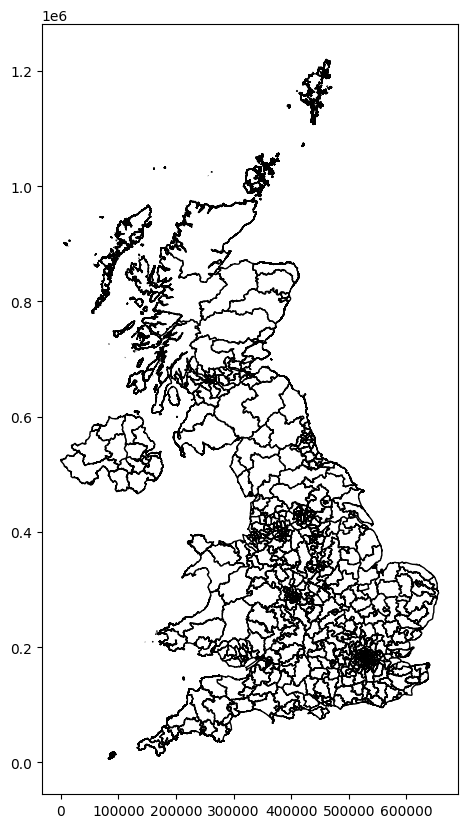

In [10]:
# do a plo to make sure these have all joined ok

fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=27700).plot(ax=ax, color="white", edgecolor="black")
plt.show()